# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython
import pickle
np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function

from agent import Person

from model import VirusModel, VirusModel_baseline


## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [3]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'pretrained', # None, 'hist'
    'expi': None,
    'fraud_det': 0,
    'fairness_metrics' : False
    
}

sample = ap.Sample(parameters, n=2)
# model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =5, record = True)
results_baseline = exp.run() 


Scheduled runs: 5
0.6025
Completed: 1, estimated time remaining: 0:01:060.5985
Completed: 2, estimated time remaining: 0:00:490.582
Completed: 3, estimated time remaining: 0:00:330.5655
Completed: 4, estimated time remaining: 0:00:160.5795
Completed: 5, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:25.086617


In [2]:
with open("/data/expis/fraud_1.pkl", "rb") as f:
       results_baseline = pickle.load(f)  

FileNotFoundError: [Errno 2] No such file or directory: '/data/expis/fraud_1.pkl'

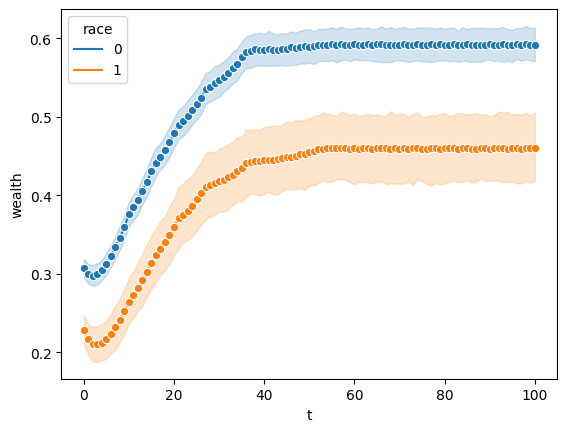

In [4]:

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

In [5]:
# # plot wealth against fraud and fraud prediction
# df_baseline['fraud_pred']
# df_baseline.index.get_level_values('t')
# a = df_baseline.loc[:,['wealth','fraud_pred']]
# # sns.violinplot(a, x = 'wealth', y = 'fraud_pred')
# df_baseline.columns = df_baseline.columns.map(''.join)
# print(df_baseline.index.names)
# df_baseline.xs('t', level=0, axis=0, drop_level=True)
# # viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['fraud_pred'])

In [6]:
parameters_b = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': None
    
}


sample_b = ap.Sample(parameters_b, n=1)
model_b = VirusModel(parameters_b)
exp = ap.Experiment(VirusModel, sample, iterations =5, record = True)
results_baseline = exp.run() 


Scheduled runs: 5
0.595
Completed: 1, estimated time remaining: 0:01:030.596
Completed: 2, estimated time remaining: 0:00:460.5925
Completed: 3, estimated time remaining: 0:00:310.6005
Completed: 4, estimated time remaining: 0:00:150.597
Completed: 5, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:19.170985


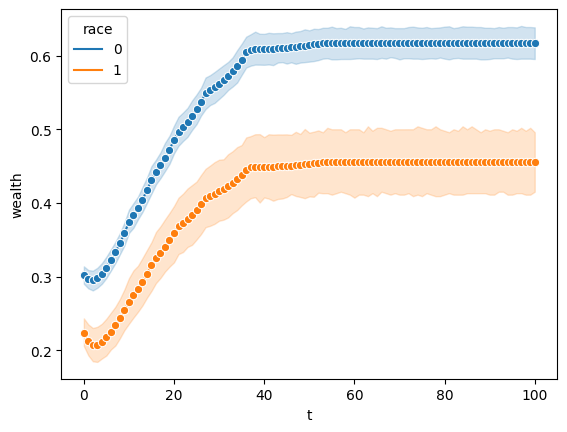

In [7]:

df = results_baseline['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [8]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [9]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_73611/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_73611/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


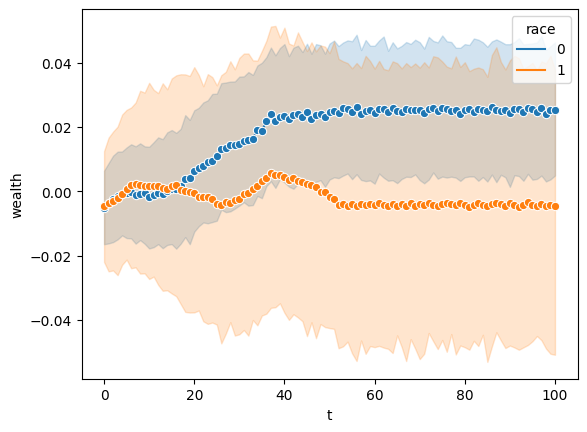

In [10]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [11]:
# run baseline and normal model and save results

exp = ap.Experiment(VirusModel_baseline, parameters, iterations =20, record=True)
results_baseline = exp.run() 

df_baseline = results_baseline['variables']['Person']

exp = ap.Experiment(VirusModel, parameters_b, iterations =20, record=True)
results = exp.run() 

df = results['variables']['Person']

Scheduled runs: 20
0.6055
Completed: 1, estimated time remaining: 0:05:130.613
Completed: 2, estimated time remaining: 0:04:530.573
Completed: 3, estimated time remaining: 0:04:360.5705
Completed: 4, estimated time remaining: 0:04:180.5835
Completed: 5, estimated time remaining: 0:04:030.598
Completed: 6, estimated time remaining: 0:03:470.581
Completed: 7, estimated time remaining: 0:03:310.59
Completed: 8, estimated time remaining: 0:03:150.5855
Completed: 9, estimated time remaining: 0:02:590.5935
Completed: 10, estimated time remaining: 0:02:420.5995
Completed: 11, estimated time remaining: 0:02:270.5805
Completed: 12, estimated time remaining: 0:02:110.604
Completed: 13, estimated time remaining: 0:01:540.577
Completed: 14, estimated time remaining: 0:01:380.59
Completed: 15, estimated time remaining: 0:01:220.5915
Completed: 16, estimated time remaining: 0:01:050.59
Completed: 17, estimated time remaining: 0:00:490.5935
Completed: 18, estimated time remaining: 0:00:320.581
Comple

/Users/uni/Documents/Git/abm/basic/utils.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1[y_axis] = df_wb1
/Users/uni/Documents/Git/abm/basic/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0[y_axis] = df_wb0


                        wealth  fraud_pred  fraud  race  gender  convicted
iteration obj_id t                                                        
0         1      0   -0.292238          -1      0     0       0          0
                 1   -0.291394           1      1     0       0          1
                 2   -0.288981           1      1     0       0          1
                 3   -0.291210           1      1     0       0          1
                 4   -0.297017           1      0     0       0          1
...                        ...         ...    ...   ...     ...        ...
19        491    96  -0.465035           1      1     1       0          1
                 97  -0.465035           1      1     1       0          1
                 98  -0.465035           1      1     1       0          1
                 99  -0.465035           1      1     1       0          1
                 100 -0.465035           1      0     1       0          1

[1010000 rows x 6 column

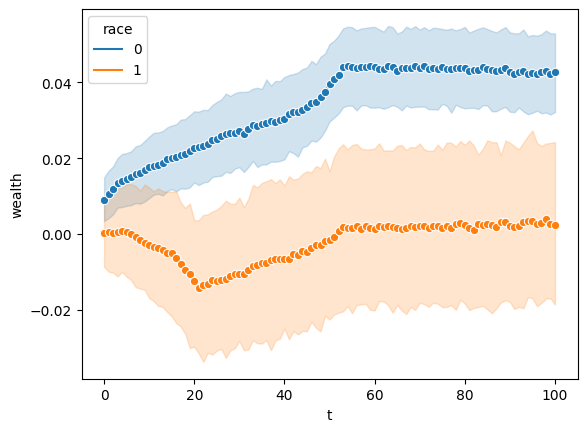

In [12]:
df_xb = delta_function('race', 'wealth', df, df_baseline)
print(df_xb)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more? This


In [13]:
# def delta_function(disc_axis, y_axis, df, df_baseline):
#     """ Delta function visualizes absolute difference between baseline scenario and more complex scenario """

#     df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
#     df_wb1 = df.iloc[(df[disc_axis] == 1).values][y_axis] - df_b1.groupby(level='t').mean()[y_axis]
#     df_x1 = df.iloc[(df[disc_axis] == 1).values]
#     df_x1[y_axis] = df_wb1
    
#     df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
#     df_wb0 = df.iloc[(df[disc_axis] == 0).values] [y_axis] - df_b0.groupby(level='t').mean()[y_axis]
#     df_x0 = df.iloc[(df[disc_axis] == 0).values]
#     df_x0[y_axis] = df_wb0
    
#     return pd.concat([df_x0, df_x1])

In [14]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0

# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])

df_xb

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_73611/296530877.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


wealth  fraud_pred  fraud  race  gender  convicted
iteration obj_id t                                                        
0         1      1   -0.097182           0      0     0       1          0
                 2   -0.098531           0      0     0       1          0
                 3   -0.098119           0      0     0       1          0
                 4   -0.097747           0      1     0       1          0
                 5   -0.098071           0      0     0       1          0
...                        ...         ...    ...   ...     ...        ...
4         498    96  -0.460377           1      0     1       1          1
                 97  -0.459618           1      1     1       1          1
                 98  -0.460181           1      1     1       1          1
                 99  -0.459802           1      1     1       1          1
                 100 -0.460165           1      1     1       1          1

[608572 rows x 6 columns]